In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from torch.utils.data import TensorDataset, DataLoader
import logging
from tqdm.notebook import tqdm

In [20]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
data_logger = logging.getLogger(" DATA")


```markdown
we are using `data0` and `data1` for training, and `data2` for testing. This setup allows us to train our model on a diverse set of data and evaluate its performance on a separate test set to ensure generalization.
```

In [21]:
#! Data processing

def load_data():
    img_data_0 = np.load('../data/data0.npy')
    img_data_1 = np.load('../data/data1.npy')
    img_data_2 = np.load('../data/data2.npy')
    img_label0 = np.load('../data/lab0.npy')
    img_label1 = np.load('../data/lab1.npy')
    img_label2 = np.load('../data/lab2.npy')

    xtrain = torch.tensor(np.concatenate((img_data_0, img_data_1)),dtype=torch.float32).unsqueeze(1)
    xtest = torch.tensor(img_data_2,dtype=torch.float32).unsqueeze(1)

    ytrain = torch.tensor(np.concatenate((img_label0, img_label1)),dtype=torch.float32)
    ytest = torch.tensor(img_label2,dtype=torch.float32)

    train_dataset = TensorDataset(xtrain, ytrain)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(xtest, ytest)

    # Split the test set into validation and test sets
    val_size = int(0.2 * len(xtest))
    test_size = len(xtest) - val_size

    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [val_size, test_size])
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    data_logger.info("Data loaded successfully")
    return {
        "train_dataloader": train_dataloader,
        "test_dataloader": test_dataloader,
        "val_dataloader": val_dataloader,
        "train_dataset": train_dataset,
        "test_dataset": test_dataset,
        "val_dataset": val_dataset,
        "xtrain": xtrain,
        "xtest": xtest,
        "ytrain": ytrain,
        "ytest": ytest
    }



In [22]:
#! visualisation

def visualize(test_dataloader,train_dataloader):
    test_data_iter = iter(test_dataloader)
    test_images, test_labels = next(test_data_iter)

    # Plot the first 4 images in the batch
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5))
    for i in range(4):
        ax = axes[i]
        ax.imshow(test_images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Label: {test_labels[i].item()}')
        ax.axis('off')
    plt.show()
    # Iterate through the DataLoader
    for i, (inputs, labels) in enumerate(train_dataloader):
        print(f"Batch {i + 1}:")
        print(f"  Input shape: {inputs.shape}")
        print(f"  Labels shape: {labels.shape}")
        # Break after the first batch to limit output (optional)
        break
    data_logger.info("Data visualisation done")


In [23]:
model_logger = logging.getLogger("MODEL")

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        # Calculate the flattened size
        self.fc1 = nn.Linear(1024*2*10, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 37) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))

        x = x.view(-1, 1024*2*10)  # Use dynamically computed size

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [25]:

# Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Squeeze-and-Excitation block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
            Swish(),
            nn.Conv2d(reduced_dim, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

# MBConv block
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride, kernel_size, reduction_ratio=4, drop_connect_rate=0.2):
        super(MBConv, self).__init__()
        mid_channels = in_channels * expand_ratio
        reduced_dim = max(1, in_channels // reduction_ratio)

        self.expand = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False) if expand_ratio != 1 else None
        self.bn1 = nn.BatchNorm2d(mid_channels) if expand_ratio != 1 else None
        self.swish = Swish()
        self.depthwise = nn.Conv2d(mid_channels, mid_channels, kernel_size=kernel_size, stride=stride,
                                   padding=kernel_size // 2, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.se = SEBlock(mid_channels, reduced_dim)
        self.pointwise = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.skip_connection = stride == 1 and in_channels == out_channels

    def forward(self, x):
        residual = x
        if self.expand:
            x = self.swish(self.bn1(self.expand(x)))
        x = self.swish(self.bn2(self.depthwise(x)))
        x = self.se(x)
        x = self.bn3(self.pointwise(x))
        if self.skip_connection:
            x += residual
        return x

# EfficientNet-like model
class EfficientNetCustom(nn.Module):
    def __init__(self, num_classes=37, dropout_rate=0.5):
        super(EfficientNetCustom, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Adjusted for 1 input channel
            nn.BatchNorm2d(32),
            Swish()
        )

        self.blocks = nn.Sequential(
            MBConv(32, 32, expand_ratio=1, stride=1, kernel_size=3),
            MBConv(32, 64, expand_ratio=6, stride=2, kernel_size=3),
            MBConv(64, 128, expand_ratio=6, stride=2, kernel_size=5),
            MBConv(128, 256, expand_ratio=6, stride=2, kernel_size=5)
        )

        self.head = nn.Sequential(
            nn.Conv2d(256, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            Swish(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model


In [26]:
class Model:
    def __init__(self):
        pass

    def set_params(self,device,net,data,optim=None,criterion=nn.CrossEntropyLoss()):
        self.device = device
        self.net = net
        self.data = data
        self.optim = optim
        self.criterion = criterion
        model_logger.info('Model Parameters Set')

    def train(self, epochs=10, lr=0.001, patience=5):
        self.net.to(self.device)
        self.net.train()
        self.optim = optim.Adam(self.net.parameters(), lr=lr) if self.optim is None else self.optim
        model_logger.info('Start Training')

        best_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(epochs), desc="Training Progress"):
            running_loss = 0.0
            val_running_loss = 0.0

            # Training phase
            self.net.train()
            for i, data in enumerate(self.data["train_dataloader"], 0):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                self.optim.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels.long())
                loss.backward()
                self.optim.step()
                running_loss += loss.item()

            # Validation phase
            self.net.eval()
            with torch.no_grad():
                for i, data in enumerate(self.data["val_dataloader"], 0):
                    inputs, labels = data[0].to(self.device), data[1].to(self.device)
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels.long())
                    val_running_loss += loss.item()

            avg_train_loss = running_loss / len(self.data["train_dataloader"])
            avg_val_loss = val_running_loss / len(self.data["val_dataloader"])

            tqdm.write(f"Epoch {epoch + 1} : Training Loss: {avg_train_loss} Validation Loss: {avg_val_loss}")

            # Early stopping
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.net.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                model_logger.info('Early stopping triggered')
                break

        model_logger.info('Finished Training')

    def test(self):
        self.net.to(self.device)
        self.net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.data["test_dataloader"]:
                images, labels = data[0].to(self.device), data[1].to(self.device)
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        model_logger.info(f'Accuracy of the network on the test images: {100 * correct / total}%')

    def save_model(self,path):
        torch.save(self.net.state_dict(), path)
        model_logger.info('Model Saved')

    def load_model(self,path):
        self.net.load_state_dict(torch.load(path))
        model_logger.info('Model Loaded')


2025-01-15 11:23:32,912 -  DATA - INFO - Data loaded successfully


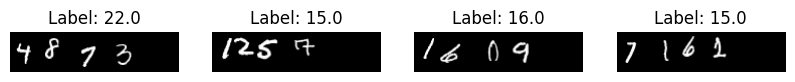

2025-01-15 11:23:33,037 -  DATA - INFO - Data visualisation done
2025-01-15 11:23:33,045 - MODEL - INFO - Model Parameters Set
2025-01-15 11:23:33,057 - MODEL - INFO - Start Training


Batch 1:
  Input shape: torch.Size([64, 1, 40, 168])
  Labels shape: torch.Size([64])
EfficientNetCustom(
  (stem): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (blocks): Sequential(
    (0): MBConv(
      (swish): Swish()
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): Swish()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(32, eps=1e-05, m

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 : Training Loss: 2.73327278710021 Validation Loss: 2.4053237214684486


In [ ]:
data = load_data()
visualize(data["test_dataloader"],data["train_dataloader"])

# net = CNN()
net = EfficientNetCustom(num_classes=37)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(net.parameters(), lr=0.003)

model = Model()
model.set_params(device,net,data,optim,criterion)
model.train(epochs=50,lr=0.003)


In [34]:
model.save_model('./model.pth')

2025-01-08 20:27:05,236 - MODEL - INFO - Model Saved
